**Terraformers Data Platform Data Queries**

First, we form a connection to the OLAP Data Warehouse. The wh_connection function accesses AWS Secrets Manager to retrieve the securely held Database credentials, then connects to the DB.

In [ ]:
from lambda3.src.lambda3_connection import wh_connection
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

conn = wh_connection()

In [ ]:
sales_gbp_by_staff_rows = conn.run("""SELECT ROUND((SUM(units_sold * unit_price)/1000000), 1)
                       AS total_mil_gbp_sold, CONCAT (first_name, ' ', last_name) AS staff_name
                       FROM fact_sales_order 
                       JOIN dim_staff
                       ON staff_id = sales_staff_id
                       JOIN dim_currency
                       ON fact_sales_order.currency_id = dim_currency.currency_id
                       WHERE dim_currency.currency_code = 'GBP'
                       GROUP BY staff_id, dim_currency.currency_code;""")
fsales_cols = [col['name'] for col in conn.columns]
df = pd.DataFrame(sales_gbp_by_staff_rows, columns=fsales_cols)
plt.barh(df['staff_name'], df['total_mil_gbp_sold'])
plt.xlabel("Total GBP sales in Million")
plt.ylabel("Staff name")
plt.title("GBP Staff revenue")
plt.show()



[[Decimal('29.7'), 'Jeremie Franey'],
 [Decimal('28.7'), 'Deron Beier'],
 [Decimal('31.2'), 'Jeanette Erdman'],
 [Decimal('24.6'), 'Ana Glover'],
 [Decimal('29.8'), 'Magdalena Zieme'],
 [Decimal('26.3'), 'Korey Kreiger'],
 [Decimal('25.9'), 'Raphael Rippin'],
 [Decimal('26.8'), 'Oswaldo Bergstrom'],
 [Decimal('27.8'), 'Brody Ratke'],
 [Decimal('25.7'), 'Jazmyn Kuhn'],
 [Decimal('24.3'), 'Meda Cremin'],
 [Decimal('29.0'), 'Imani Walker'],
 [Decimal('24.7'), 'Stan Lehner'],
 [Decimal('31.9'), 'Rigoberto VonRueden'],
 [Decimal('28.7'), 'Tom Gutkowski'],
 [Decimal('25.9'), 'Jett Parisian'],
 [Decimal('27.0'), "Irving O'Keefe"],
 [Decimal('30.9'), 'Tomasa Moore'],
 [Decimal('28.8'), 'Pierre Sauer'],
 [Decimal('25.6'), 'Flavio Kulas']]

['total_mil_gbp_sold', 'staff_name']

In [ ]:
df

,total_mil_gbp_sold,staff_name
0,29.7,Jeremie Franey
1,28.7,Deron Beier
2,31.2,Jeanette Erdman
3,24.6,Ana Glover
4,29.8,Magdalena Zieme
5,26.3,Korey Kreiger
6,25.9,Raphael Rippin
7,26.8,Oswaldo Bergstrom
8,27.8,Brody Ratke
9,25.7,Jazmyn Kuhn


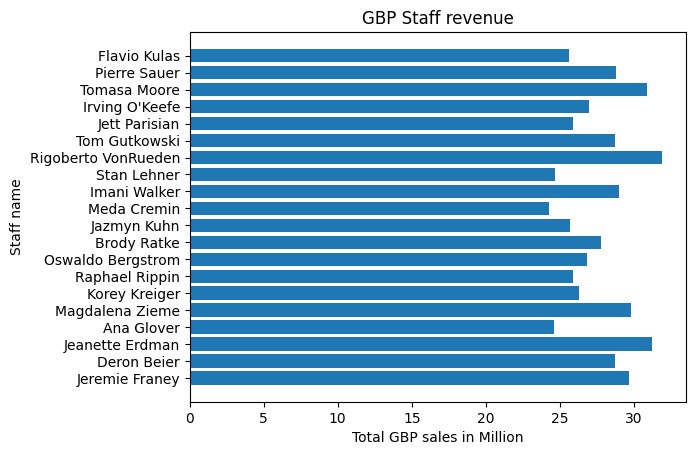